In [1]:
%load_ext autoreload

In [2]:
from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

from utils.min_norm_solvers_numpy import MinNormSolver, gradient_normalizers


from envs.environment_visualization_utils import plot_values, plot_mars, plot_reward_map, plot_texture_map, plot_tile_map
from envs.environment_setup_utils import get_mdp
from utils.tf_utils import save_tf_vars, load_tf_vars, os_setup
from utils.soft_q_learning import tabsoftq_learn_Qs, tabsoftq_gen_pol, generate_demonstrations, vectorize_rollouts
from utils.data_utils import initialize_scopes, load_scopes
from utils.learning_utils import generate_constraints, nn_vectorize_rollouts, get_rollout_indexes, sample_batch
from envs.environment_utils import featurize_states
from utils.demos_utils import get_demos
from utils.experiment_utils import current_milli_time
from utils.models import InverseDynamicsLearner


In [3]:
%autoreload 2

# Environment Setup

In [4]:
os_setup()
data_dir = os.path.join('data', '1.1')
out_dir = os.path.join("logs", "models", str(current_milli_time()))
mdp = get_mdp(0)

In [5]:
#visualization demos

#plot_reward_map(mdp)
#plot_texture_map(mdp)
#plot_tile_map(mdp)

In [6]:
mdp.adt_mat

array([[[0.8  , 0.1  , 0.   , 0.1  , 0.   ],
        [0.1  , 0.8  , 0.1  , 0.   , 0.   ],
        [0.   , 0.1  , 0.8  , 0.1  , 0.   ],
        [0.1  , 0.   , 0.1  , 0.8  , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 1.   ]],

       [[0.001, 0.   , 0.   , 0.   , 0.999],
        [0.   , 0.001, 0.   , 0.   , 0.999],
        [0.   , 0.   , 0.001, 0.   , 0.999],
        [0.   , 0.   , 0.   , 0.001, 0.999],
        [0.   , 0.   , 0.   , 0.   , 1.   ]]])

# Soft-Q Learning for Demonstrations

Sanity check (env and softq)

In [7]:
#temp_Q = tabsoftq_learn_Qs(mdp, gamma=0.95)
#plot_mars(mdp, tabsoftq_gen_pol(temp_Q*50), Qs=temp_Q)


# Model Set Up

In [8]:
gamma = 0.99
alpha = 1e-4
beta1 = 0.9
beta2 = 0.999999
sq_td_err_penalty = 1
trans_penalty = 1
t_err_penalty = 1e0
q_err_penalty = 1e0
constraint_batch_size = 512

q_n_layers = 2
q_layer_size = 2048
q_activation = tf.nn.tanh
q_output_activation = None

dyn_n_layers = 1
dyn_layer_size = 256
dyn_activation = tf.nn.relu
dyn_output_activation = None


# Boltz-beta determines the "rationality" of the agent being modeled.
# Setting it to higher values corresponds to "pure rationality"
boltz_beta = 50

batch_size=512

In [9]:
###### UNCOMMENT WHEN FIRST RUNNING THIS NOTEBOOK #######
# initialize_scopes(data_dir)
q_scope, dyn_scope = load_scopes(data_dir)
sess = tf.Session()

mlp_params = {'q_n_layers':q_n_layers,
                  'q_layer_size':q_layer_size,
                  'q_activation': q_activation,
                  'q_output_activation':q_output_activation,
                  'dyn_n_layers':dyn_n_layers,
                  'dyn_layer_size':dyn_layer_size,
                  'dyn_activation':dyn_activation,
                  'dyn_output_activation':dyn_output_activation}

model = InverseDynamicsLearner(mdp, sess, mlp_params=mlp_params, boltz_beta=boltz_beta, gamma=gamma)

# IDL Experiments

## Demo setup

In [10]:
#DEMO Config
gamma_demo = 0.99
n_demos = 200
demo_time_steps = 40
temp_boltz_beta = 50

In [25]:
constraints, rollouts, train_idxes, val_demo_batch, true_qs, q_states, adt_samples = get_demos(
    mdp, gamma, temp_boltz_beta, n_demos, demo_time_steps)

## Weighted Optimization

In [12]:
# Coordinate Config
batch_size = 200
n_training_iters = 5000
horizon = 1000
# Config made up of ['nall', 'ntll', 'tde', 'tde_sg_q', 'tde_sg_t']
losses = [1] #[0,1,2]
weights = [5.0] #[1.0,1.0,0.2]

In [13]:
regime_params = {"losses": losses,
                 'loss_weights':weights}

In [14]:
model.initialize_training_regime("weighted", regime_params=regime_params)

## Coordinate Descent

In [11]:
# Coordinate Config
batch_size = 200
n_training_iters = 5000
horizon = 1000
slope_threshold = 1e-4
switch_frequency = 500
# Config made up of ['nall', 'ntll', 'tde', 'tde_sg_q', 'tde_sg_t']
initial_update = [1]
update_progression = [[0,3],[1,4]]

In [12]:
regime_params = {"horizon": horizon,
                 'slope_threshold':slope_threshold,
                 'switch_frequency': switch_frequency,
                 'initial_update': initial_update,
                 'update_progression':update_progression}

In [13]:
model.initialize_training_regime("coordinate", regime_params=regime_params)

## Frank Wolfe

In [18]:
batch_size = 200
n_training_iters = 1000
loss_configurations = [[0,3],[1,4]]

In [19]:
regime_params = {'loss_configurations':loss_configurations}
model.initialize_training_regime("MGDA", regime_params=regime_params)

## Training

In [15]:
model.train(n_training_iters, rollouts, train_idxes, batch_size, constraints, val_demo_batch, out_dir, q_states, adt_samples, tab_save_freq=50)

[('nall', 6.024446), ('ntll', 1.270582), ('tde', 4.17337), ('weighted_loss', 6.35291)]
[('nall', 6.024446), ('ntll', 0.7143428), ('tde', 4.1732674), ('weighted_loss', 3.571714)]
Experiment Interrupted at timestep 174


('logs/models/1556648987078/q_fn',
 'logs/models/1556648987078/dyn_fn',
 'logs/models/1556648987078/dyn_fn',
 {'nall': [6.224424,
   6.2120824,
   5.781803,
   5.9542556,
   5.8647947,
   6.313971,
   6.0190053,
   6.036001,
   6.3163233,
   6.186979,
   6.046012,
   5.8517137,
   6.0455513,
   5.835209,
   5.873258,
   5.954986,
   6.2422924,
   6.13797,
   6.068069,
   6.005713,
   6.175894,
   6.3025236,
   6.04243,
   5.815486,
   5.816875,
   5.8426294,
   6.080193,
   6.153763,
   6.241331,
   6.1112866,
   6.145094,
   6.025636,
   6.1159077,
   5.911348,
   6.1527867,
   6.0514402,
   6.27519,
   6.272431,
   5.862728,
   6.1808887,
   5.867039,
   6.375101,
   6.224103,
   5.9037075,
   6.213447,
   6.2158113,
   6.311551,
   6.358987,
   5.8889265,
   5.9909043,
   6.113043,
   6.0398912,
   6.18442,
   6.2377944,
   6.077087,
   6.116814,
   6.181341,
   5.761721,
   6.0931396,
   5.600084,
   6.121117,
   6.2365804,
   5.9457436,
   6.390989,
   5.8317933,
   6.1236506,
   

## Visualization

In [18]:
from utils.metric_utils import get_all_dynamics_distances
import glob

In [19]:
true_dyn = mdp.adt_mat

In [20]:
file_header = "logs/models/1556648987078/tab/adt_probs"

model_files = glob.glob(file_header + "*")

iters_models = [(int(file.split("_")[-1].split(".")[0]), pkl.load(open(file, 'rb'))) for file in model_files]

iters_models = sorted(iters_models, key=lambda x: x[0])

iters, models = zip(*iters_models)

In [21]:
observed_diffs = [np.linalg.norm(true_dyn[0] - model[0]) for model in models]
unobserved_diffs = [np.linalg.norm(true_dyn[1] - model[1]) for model in models]

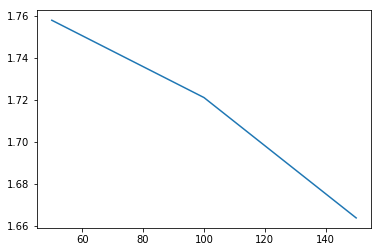

In [22]:
plt.plot(iters, observed_diffs)

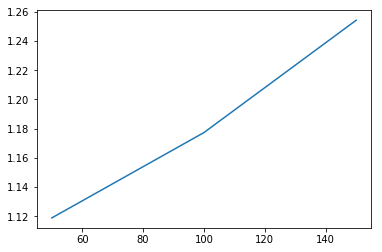

In [23]:
plt.plot(iters, unobserved_diffs)

In [24]:
true_qs = true_qs.reshape((mdp.num_actions, mdp.num_states)).transpose()

In [55]:
file_header = "logs/models/1556648987078/tab/q_vals"

model_files = glob.glob(file_header + "*")

iters_models = [(int(file.split("_")[-1].split(".")[0]), pkl.load(open(file, 'rb'))) for file in model_files]

iters_models = sorted(iters_models, key=lambda x: x[0])

iters, models = zip(*iters_models)

In [56]:
true_qs

array([[ 0.02324234, -0.03094444,  0.11219458, -0.03762808,  0.03608519],
       [ 0.16237879, -0.05083176, -0.01058735, -0.09629976,  0.04523062],
       [ 0.03160818, -0.05734967, -0.04145217, -0.04067931,  0.10089207],
       [ 0.05527093, -0.09774989,  0.00795057, -0.145381  ,  0.03007375],
       [ 0.06730623,  0.00609156, -0.07176784, -0.05965118,  0.00954518],
       [-0.03722327, -0.04955059,  0.09382902, -0.07602263, -0.01448885],
       [ 0.08388913,  0.00442968, -0.06792401, -0.03847174,  0.14639406],
       [ 0.10351442, -0.12159532, -0.0444164 , -0.06638671,  0.02652709],
       [ 0.13971186, -0.0496444 ,  0.02851866, -0.06400628,  0.00199082],
       [ 0.00068898,  0.02886973,  0.15391544,  0.03724255,  0.06591805],
       [ 0.13982907,  0.0089612 ,  0.03128685, -0.02132968,  0.07490221],
       [ 0.00895408,  0.00227055,  0.00024856,  0.03426944,  0.13078636],
       [ 0.03266486, -0.03780577,  0.04949082, -0.07058737,  0.0602323 ],
       [ 0.04461312,  0.06595496, -0.0

In [57]:
q_diffs = [np.linalg.norm(true_qs - model) for model in models]
plt.plot(iters, q_diffs)

ValueError: operands could not be broadcast together with shapes (405,) (81,5) 

## Testing Training Results

In [16]:
# Sample full dynamics model
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

NameError: name 'adt_pred_dir' is not defined

In [17]:
# Print learned dynamics
softmax(adt_probs)

NameError: name 'softmax' is not defined

In [18]:
# Sample full q-fn model
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

NameError: name 'constraint_q_ts' is not defined

In [19]:
# Plot learned q-values and true q-values
plot_values(mdp, q_vals)
plot_values(mdp, Qs)

NameError: name 'q_vals' is not defined

In [20]:
# More comprehensive debugging stuff

test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

NameError: name 'constraint_rew_t_ph' is not defined

In [21]:
# Q-fn Model Storage
q_net_path = os.path.join(data_dir, 'adt_true_q.tf')
save_tf_vars(sess, q_scope, q_net_path)

In [72]:
# Dynamics Model Storage
invadt_path = os.path.join(data_dir, 'adt_fw_t.tf')
save_tf_vars(sess, invadt_scope, invadt_path)

In [73]:
# Training data Storage
pkl.dump(mode_logs, open('adt_fw.pkl', 'wb'))